In [1]:
import os
import pandas as pd
import unidecode
from datetime import time
import numpy as np


# PROCESSING ET CLEANING ✅

In [2]:
# Charger les fichiers CSV
def load_csv_files(csv_folder, file_prefix="EXP_", sep=';'):
    dataframes = {}
    files = [f for f in os.listdir(csv_folder) if f.startswith(file_prefix) and f.endswith(".csv")]
    for file in files:
        df_name = file.replace(file_prefix, "").replace(".csv", "").capitalize()
        df = pd.read_csv(os.path.join(csv_folder, file), sep=sep)
        dataframes[df_name] = df
    return dataframes

# Sélection et renommage des colonnes
def select_and_rename_columns(dataframes, config):
    for name, settings in config.items():
        if name in dataframes:
            df = dataframes[name]
            if 'keep' in settings:
                df = df[settings['keep']]
            if 'rename' in settings:
                df.rename(columns=settings['rename'], inplace=True)
            if 'drop_pattern' in settings:
                drop_cols = df.filter(regex=settings['drop_pattern']).columns
                df.drop(columns=drop_cols, inplace=True)
            dataframes[name] = df

# Nettoyage des noms de colonnes
def clean_column_names(dataframes):
    for name, df in dataframes.items():
        df.columns = [unidecode.unidecode(col).lower().replace(" ", "_").replace("-", "_") for col in df.columns]
        dataframes[name] = df

# Conversion des types avec gestion spécifique pour la colonne `sur`
def convert_column_types(dataframes, column_types):
    for name, df in dataframes.items():
        for col in df.columns:
            # Conversion des colonnes string
            if col in column_types.get('string', []):
                df[col] = df[col].astype(str)

            # Conversion spécifique pour la colonne `sur`
            elif col == 'sur':
                # Extraire la valeur après '/' et convertir en entier
                df[col] = pd.to_numeric(df[col].astype(str).str.replace('/', ''), errors='coerce').astype('Int64')

            # Conversion des colonnes float
            elif col in column_types.get('float', []):
                df[col] = pd.to_numeric(df[col].astype(str).str.replace(',', '.'), errors='coerce')

            # Conversion des colonnes int
            elif col in column_types.get('int', []) and col != 'sur':  # Exclure `sur` pour éviter un double traitement
                # Convertir d'abord en float pour traiter les valeurs décimales et les `NaN`
                temp_col = pd.to_numeric(df[col].astype(str).str.replace(',', '.'), errors='coerce')

                # Vérifier si toutes les valeurs non `NaN` sont des entiers
                if (temp_col.dropna() % 1 == 0).all():
                    # Convertir en `Int64` en utilisant `.fillna(np.nan).astype('Int64')`
                    df[col] = temp_col.fillna(np.nan).astype('Int64')
                else:
                    # Si des valeurs décimales existent, laisser en `float`
                    df[col] = temp_col

            # Conversion des colonnes date
            elif col in column_types.get('date', []):
                df[col] = pd.to_datetime(df[col], errors='coerce', dayfirst=True)

            # Conversion des colonnes time
            elif col in column_types.get('time', []):
                df[col] = pd.to_datetime(df[col].astype(str).str.replace('h', ':'), format='%H:%M', errors='coerce').dt.time

            # Conversion des colonnes category
            elif col in column_types.get('category', []):
                df[col] = df[col].astype('category')

        # Mettre à jour le DataFrame dans le dictionnaire
        dataframes[name] = df

def anonymize_students(dataframes, eleve_df, ident_column='ident'):
    """
    Anonymise les informations des élèves dans les DataFrames spécifiés.

    Parameters:
        dataframes (dict): Dictionnaire de DataFrames à anonymiser.
        eleve_df (DataFrame): DataFrame contenant les informations des élèves avec l'identifiant.
        ident_column (str): Nom de la colonne d'identifiant dans eleve_df (par défaut 'ident').
    """
    # Créer le mapping pour les élèves
    eleve_mapping = {f"{row['nom']} {row['prenom']}": row[ident_column] for _, row in eleve_df.iterrows()}

    # Liste des DataFrames à anonymiser pour les élèves
    student_dfs = ['Punition', 'Notes','Notesdevoir_t1','Notesdevoir_t2', 'Notesdevoir_t3', 'Absenceseleves', 'Retards', 'Appreciationprofesseurs',
                   'Passagesinfirmerie', 'Appreciationduconseil', 'Sanction', 'Notes','Absencerepas']

    for name in student_dfs:
        if name in dataframes:
            df = dataframes[name]
            if 'nom' in df.columns and 'prenom' in df.columns:
                df['nom_prenom'] = df['nom'] + ' ' + df['prenom']
                df['eleve_id'] = df['nom_prenom'].map(eleve_mapping)
                df.drop(columns=['nom', 'prenom', 'nom_prenom'], inplace=True)
                dataframes[name] = df

def anonymize_professors(dataframes, professor_df, ident_column='ident'):
    """
    Anonymise les informations des professeurs dans les DataFrames spécifiés.

    Parameters:
        dataframes (dict): Dictionnaire de DataFrames à anonymiser.
        professor_df (DataFrame): DataFrame contenant les informations des professeurs avec l'identifiant.
        ident_column (str): Nom de la colonne d'identifiant dans professor_df (par défaut 'ident').
    """
    # Créer le mapping pour les professeurs
    professor_df['nom_complet'] = professor_df['nom'] + ' ' + professor_df['prenom']
    prof_mapping = {row['nom_complet']: row[ident_column] for _, row in professor_df.iterrows()}

    # Liste des DataFrames à anonymiser pour les professeurs
    professor_dfs = ['Notesdevoir_t1','Notesdevoir_t2', 'Notesdevoir_t3', 'Appreciationprofesseurs', 'Service', 'Notes']

    for name in professor_dfs:
        if name in dataframes and 'profs' in dataframes[name].columns:
            df = dataframes[name]
            df['profs_standard'] = df['profs'].str.replace(r'^M\.|Mme\s+', '', regex=True).str.strip()
            df['prof_id'] = df['profs_standard'].map(prof_mapping)
            df.drop(columns=['profs', 'profs_standard'], inplace=True)
            dataframes[name] = df


In [3]:
# Configurer la sélection et le renommage des colonnes
columns_config = {
    'Punition': {
        'keep': ['NOM', 'PRENOM', 'CLASSES', 'PUNITION', 'DATE', 'MOTIF', 'HEURE']
    },
    'Notesdevoir_t1': {
        'keep': ['CLASSES', 'NOM', 'PRENOM', 'PROFS', 'MATIERE', 'DATE', 'P1', 'SUR', 'COEFF', 'NOTE'],
        'rename': {'P1': 'TRIMESTRE'}

    },
    'Notesdevoir_t2': {
        'keep': ['CLASSES', 'NOM', 'PRENOM', 'PROFS', 'MATIERE', 'DATE', 'P1', 'SUR', 'COEFF', 'NOTE'],
        'rename': {'P1': 'TRIMESTRE'}

    },
    'Notesdevoir_t3': {
        'keep': ['CLASSES', 'NOM', 'PRENOM', 'PROFS', 'MATIERE', 'DATE', 'P1', 'SUR', 'COEFF', 'NOTE'],
        'rename': {'P1': 'TRIMESTRE'}

    },

    'Professeur': {
        'keep': ['IDENT', 'CIVILITE', 'NOM', 'PRENOM']
    },
    'Absenceseleves': {
        'keep': ['NOM', 'PRENOM', 'CLASSES', 'MOTIF', 'DATE DEBUT', 'DEMI JOUR'],
        'rename': {'DATE DEBUT': 'DATE', 'DEMI JOUR': 'NB_DEMI_JOURNEE'}
    },
    'Absencerepas': {
        'keep': ['NOM', 'PRENOM', 'CLASSES', 'DATE']
    },
    'Retards': {
        'keep': ['NOM', 'PRENOM', 'CLASSES', 'MOTIF', 'REGLE', 'DATE', 'HEURE', 'DUREE']
    },
    'Eleve': {
        'keep': ['IDENT', 'NOM', 'PRENOM', 'DATE NAISS', 'CLASSES', 'SEXE'],
        'rename': {'DATE NAISS': 'DATE_NAISS'}
    },
    'Service': {
        'keep': ['MATIERE', 'CLASSES', 'PROFS', 'NB DEVOIRS', 'COEFF'],
        'rename': {'NB DEVOIRS': 'NB_DEVOIRS'}
    },
    'Appreciationprofesseurs': {
        'keep': ['NOM', 'PRENOM', 'MATIERE', 'CLASSE/GRPE', 'PROFS', 'PERIODE', 'APPR.A'],
        'rename': {'CLASSE/GRPE': 'CLASSE', 'APPR.A': 'APPR','PERIODE':'trimestre'}
    },
    'Passagesinfirmerie': {
        'keep': ['NOM', 'PRENOM', 'CLASSES', 'H DEBUT', 'DATE', 'DUREE'],
        'rename': {'H DEBUT': 'HEURE'}
    },
    'Appreciationduconseil': {
        'keep': ['NOM', 'PRENOM', 'CLASSES', 'PERIODE', 'APPR.C'],
        'rename': {'APPR.C': 'APPR'}
    },
    'Sanction': {
        'keep': ['NOM', 'PRENOM', 'CLASSES', 'DATE', 'SANCTION', 'MOTIF']
    },
    'Notes': {
        'keep': ['PROFS', 'MATIERE', 'CLASSE/GRPE', 'NOM ELEVE', 'PRENOM ELEVE', 'MOY_ELEVE'] +
                [f'Devoir{i} - Note' for i in range(1, 25)] +
                [f'Devoir{i} - Coeff' for i in range(1, 25)] +
                [f'Devoir{i} - Date' for i in range(1, 25)] +
                [f'Devoir{i} - Période Notation' for i in range(1, 25)],
                'rename': {'NOM ELEVE': 'NOM', 'PRENOM ELEVE':'PRENOM'},
        'drop_pattern': 'Devoir\d+ - Facultatif'
    }
}

# Configurer les types de colonnes
column_types = {
    'string': ['nom', 'prenom', 'classes','profs', 'civilite', 'motif', 'punition', 'regle','trimestre'],
    'float': ['note', 'moyenne'],
    'int': ['nb_demi_journee', 'nb_devoirs','coeff', 'sur'],
    'date': ['date', 'date_naiss', 'periode'],
    'time': ['heure', 'duree'],
    'category': ['classe', 'trimestre', 'matiere', 'sexe']
}


# Application
csv_folder_path = "../../../raw_data/Daudet/2023-2024/Pronote/"

#extraction des données
data_pronote = load_csv_files(csv_folder=csv_folder_path)

#selection des colonnes
select_and_rename_columns(data_pronote, columns_config)

#cleaning des noms de colonnes
clean_column_names(data_pronote)

#cleaning des types de colonnes
convert_column_types(data_pronote, column_types)

# Appliquer l'anonymisation des élèves
anonymize_students(data_pronote, data_pronote['Eleve'])

# Appliquer l'anonymisation des professeurs
anonymize_professors(data_pronote, data_pronote['Professeur'])

/var/folders/p9/_030_tzn0cx_x11mkmfz6w800000gn/T/ipykernel_10238/2906436130.py:7: DtypeWarning: Columns (81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(os.path.join(csv_folder, file), sep=sep)
/var/folders/p9/_030_tzn0cx_x11mkmfz6w800000gn/T/ipykernel_10238/2906436130.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.rename(columns=settings['rename'], inplace=True)
/var/folders/p9/_030_tzn0cx_x11mkmfz6w800000gn/T/ipykernel_10238/2906436130.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation

#### Tous les dataframes sont crées, structurés, nettoyées, anonymisés ✅

In [4]:
df_notes_devoir.groupby('classes')['matiere'].apply(lambda x: list(x.unique())).reset_index(name='matieres')


NameError: name 'df_notes_devoir' is not defined

In [ ]:
df_notes_devoir['matiere'].unique()

array(['Français', 'SPC', 'Mathématiques', 'Hist-Géo/EMC', 'Arabe', 'SVT',
       'Anglais', 'EPS', 'Espagnol', 'HG Arabe', 'SES', 'SNT',
       'Philosophie', nan], dtype=object)

# DF_NOTES

In [ ]:
# Ajouter une colonne 'trimestre' pour chaque DataFrame avant de les concaténer
data_pronote['Notesdevoir_t1']['trimestre'] = 'Trimestre 1'
data_pronote['Notesdevoir_t2']['trimestre'] = 'Trimestre 2'
data_pronote['Notesdevoir_t3']['trimestre'] = 'Trimestre 3'

# Concaténer les trois DataFrames
df_notes_devoir = pd.concat([
    data_pronote['Notesdevoir_t1'],
    data_pronote['Notesdevoir_t2'],
    data_pronote['Notesdevoir_t3']
], ignore_index=True)

# Afficher un aperçu du DataFrame concaténé
df_notes_devoir.head()

,classes,matiere,date,trimestre,sur,coeff,note,eleve_id,prof_id
0,1A,FRANÇAIS,2023-09-21,Trimestre 1,20,1.0,13.0,x98XOvwoNyehe5aGZFC4QGm8ZPyM6Sof0LJwXpfNP-c,0-qkoCBCeu1-A2WvQZEecuK98nvosoTdzUTdiI6lwDo
1,1A,ENSEIGNEMENT SCIENTIFIQUE (PC),2023-09-25,Trimestre 1,20,0.5,7.0,x98XOvwoNyehe5aGZFC4QGm8ZPyM6Sof0LJwXpfNP-c,zalvxQljlC_iyENJQK4qClMhXqp3ZogCFPq9JR9Yalw
2,1A,SPE MATHS,2023-09-26,Trimestre 1,20,1.0,8.0,x98XOvwoNyehe5aGZFC4QGm8ZPyM6Sof0LJwXpfNP-c,JumFXm1J2Jm1zAFbJ-KKVcMFxl2mfiu882gBggAozMg
3,1A,HISTOIRE GEOGRAPHIE,2023-09-27,Trimestre 1,10,1.0,5.0,x98XOvwoNyehe5aGZFC4QGm8ZPyM6Sof0LJwXpfNP-c,MkTDEy0fzub_lzFNRBxLLG0sLd5mzSpMxX3wx8l6Guo
4,1A,ARABE LVA,2023-10-04,Trimestre 1,20,2.0,12.0,x98XOvwoNyehe5aGZFC4QGm8ZPyM6Sof0LJwXpfNP-c,t8jRAdLt_P0Ai2D2pyBamlLBFMnN_k9Od6ycTUB98oA


In [ ]:
# Listes des classes pour chaque niveau
lycee_classes = ['1A', '1B/C', '2A', '2B', '2C', 'Terminale']
college_classes = ['3A', '3B', '3C', '4A', '4B', '4C', '5A', '5B', '5C', '6A', '6B', '6C']

# Fonction pour déterminer le niveau
def determiner_niveau(classe):
    if classe in lycee_classes:
        return 'lycée'
    elif classe in college_classes:
        return 'collège'
    else:
        return 'N/A'  # Si la classe ne correspond à aucun niveau défini

# Application de la fonction pour créer la colonne 'niveau de classe'
df_notes_devoir['niveau'] = df_notes_devoir['classes'].apply(determiner_niveau)

mapping_niveau = {
        '6A': '6e', '6B': '6e', '6C': '6e',
        '5A': '5e', '5B': '5e', '5C': '5e',
        '4A': '4e', '4B': '4e', '4C': '4e',
        '3A': '3e', '3B': '3e', '3C': '3e',
        '2A': 'Seconde', '2B': 'Seconde', '2C': 'Seconde',
        '1A': 'Première', '1B/C': 'Première', 'Terminale': 'Terminale'
    }
df_notes_devoir['niveau_de_classe'] = df_notes_devoir['classes'].map(mapping_niveau)
data_pronote['Appreciationprofesseurs']['niveau_de_classe'] = data_pronote['Appreciationprofesseurs']['classe'].map(mapping_niveau)


mapping_matiere = {
    'FRANÇAIS': 'Français',
    'ENSEIGNEMENT SCIENTIFIQUE (PC)': 'SPC',
    'SPE MATHS': 'Mathématiques',
    'HISTOIRE GEOGRAPHIE': 'Hist-Géo/EMC',
    'ARABE LVA': 'Arabe',
    'SPE PC': 'SPC',
    'SPE SVT': 'SVT',
    'ANGLAIS LVB': 'Anglais',
    'Éducation physique et sportive': 'EPS',
    'ENSEIGNEMENT SCIENTIFIQUE (SVT)': 'SVT',
    'EMC': 'Hist-Géo/EMC',
    'ESPAGNOL': 'Espagnol',
    'APPROFONDISSEMENT CULTUREL ET LINGUISTIQUE': 'Anglais',
    'HISTOIRE GEOGRAPHIE EN ARABE': 'HG Arabe',
    'ARABE BFI (CDM)': 'Arabe',
    'ANGLAIS LVB BFI (ACL)': 'Anglais',
    'SPE HGGSP': 'Hist-Géo/EMC',
    'SPE SES': 'SES',
    'MATHS TRONC COMMUN': 'Mathématiques',
    'MATHEMATIQUES': 'Mathématiques',
    'SPC': 'SPC',
    'SES': 'SES',
    'SVT': 'SVT',
    'SNT': 'SNT',
    'ARABE SI': 'Arabe',
    'HIST GEO NA': 'Hist-Géo/EMC',
    'PHILOSOPHIE': 'Philosophie',
    'MATHS EXPERTES': 'Mathématiques',
    'ARABE LV SECTION': 'Arabe',
    'MATHS COMPLEMENTAIRES': 'Mathématiques'
}

df_notes_devoir['matiere'] = df_notes_devoir['matiere'].map(mapping_matiere)
data_pronote['Appreciationprofesseurs']['matiere'] = data_pronote['Appreciationprofesseurs']['matiere'].map(mapping_matiere)


# Calcul de la note pondérée en normalisant sur 20 et appliquant le coefficient
df_notes_devoir['note_ponderee'] = (df_notes_devoir['note'] / df_notes_devoir['sur']) * 20 * df_notes_devoir['coeff']

In [6]:
# Renommer la colonne `ident` dans df_eleve pour correspondre à `eleve_id`
data_pronote['Eleve'].rename(columns={'ident': 'eleve_id'}, inplace=True)

# DataFrame pour la réidentification (avec 'eleve_id', 'nom', 'prenom')
df_reidentification_eleve = data_pronote['Eleve'][['eleve_id', 'nom', 'prenom']]

# DataFrame pour l'analyse (avec 'eleve_id', 'date_naiss', 'classes', 'sexe')
data_pronote['Eleve'] = data_pronote['Eleve'][['eleve_id', 'date_naiss', 'classes', 'sexe']]


# Merge des deux DataFrames sur la colonne 'eleve_id'
data_pronote['Appreciationprofesseurs'] = data_pronote['Appreciationprofesseurs'].merge(
    data_pronote['Eleve'][['eleve_id', 'sexe']],  # On garde seulement les colonnes nécessaires
    on='eleve_id',                  # Clé de jointure
    how='left'                      # Jointure gauche pour ne pas perdre de données dans df_appreciationprofesseurs
)


In [ ]:
# DataFrame pour la réidentification (avec 'prof_id', 'nom', 'prenom')
df_reidentification_prof = data_pronote['Professeur'][['ident', 'nom', 'prenom']].rename(columns={'ident': 'prof_id'})

In [ ]:

# Chemin du dossier d'exportation
export_folder_for_streamlit = "streamlit/data_app"
os.makedirs(export_folder_for_streamlit, exist_ok=True)# Crée le dossier s'il n'existe pas

export_folder_for_not_for_streamlit= "exported_data"
os.makedirs(export_folder_for_not_for_streamlit, exist_ok=True)# Crée le dossier s'il n'existe pas

# Fonction pour exporter les DataFrames dans le dossier spécifié
def export_dataframes(dataframes, folder_path):
    """
    Vide le dossier d'exportation et exporte chaque DataFrame dans un fichier CSV distinct dans le dossier spécifié.

    Parameters:
        dataframes (dict): Dictionnaire contenant les DataFrames à exporter.
        folder_path (str): Chemin du dossier d'exportation.
    """
    # Supprimer tous les fichiers existants dans le dossier d'exportation
    for filename in os.listdir(folder_path):
        file_path = os.path.join(folder_path, filename)
        if os.path.isfile(file_path):  # Vérifie que c'est un fichier
            os.remove(file_path)

    # Exporter chaque DataFrame dans un fichier CSV
    for name, df in dataframes.items():
        file_path = os.path.join(folder_path, f"{name}.csv")  # Chemin complet du fichier
        df.to_csv(file_path, index=False, sep=';', encoding='utf-8')  # Export en CSV avec ';' comme séparateur
        print(f"DataFrame '{name}' exporté vers {file_path}")


# Ajout de tous les DataFrames à exporter, y compris ceux dans `data_pronote`
dataframes_to_export_for_streamlit = {
    'df_notes_devoir': df_notes_devoir,                # DataFrame avec les notes par devoir
    'df_eleve':data_pronote['Eleve'],
    'df_absenceseleves': data_pronote['Absenceseleves'],
    'df_retards' : data_pronote['Retards'],
    'df_punition' : data_pronote['Punition'],
    'df_passagesinfirmerie' :data_pronote['Passagesinfirmerie'],
    'df_sanction' : data_pronote['Sanction'],
    'df_appreciationprofesseurs':data_pronote['Appreciationprofesseurs']
}


dataframes_to_export_for_df_reidentification = {
    'df_reidentification_eleve': df_reidentification_eleve,                # DataFrame avec les notes par devoir
    'df_reidentification_prof':df_reidentification_prof
    }

# Exporter tous les DataFrames
export_dataframes(dataframes_to_export_for_streamlit, export_folder_for_streamlit)
export_dataframes(dataframes_to_export_for_df_reidentification, export_folder_for_not_for_streamlit)


DataFrame 'df_notes_devoir' exporté vers streamlit/data_app/df_notes_devoir.csv
DataFrame 'df_eleve' exporté vers streamlit/data_app/df_eleve.csv
DataFrame 'df_absenceseleves' exporté vers streamlit/data_app/df_absenceseleves.csv
DataFrame 'df_retards' exporté vers streamlit/data_app/df_retards.csv
DataFrame 'df_punition' exporté vers streamlit/data_app/df_punition.csv
DataFrame 'df_passagesinfirmerie' exporté vers streamlit/data_app/df_passagesinfirmerie.csv
DataFrame 'df_sanction' exporté vers streamlit/data_app/df_sanction.csv
DataFrame 'df_appreciationprofesseurs' exporté vers streamlit/data_app/df_appreciationprofesseurs.csv
DataFrame 'df_reidentification_eleve' exporté vers exported_data/df_reidentification_eleve.csv
DataFrame 'df_reidentification_prof' exporté vers exported_data/df_reidentification_prof.csv


In [7]:
data_pronote['Appreciationprofesseurs']

,matiere,classe,trimestre,appr,eleve_id,prof_id,sexe
0,HISTOIRE GEOGRAPHIE,Terminale,Trimestre 1,Un début d'année en douceur pour Mamoun. Il fa...,cOEtYHptjUxWchHTfvof0dyKnZzEkEypQkjoamXFzgM,NaTUeIaRZA9cPVkJaVYXHesRe7jqnQ2GpN6t1ycqJz8,M
1,HISTOIRE GEOGRAPHIE,Terminale,Trimestre 2,Mmaoun a réalisé un bon trimestre. Il a démont...,cOEtYHptjUxWchHTfvof0dyKnZzEkEypQkjoamXFzgM,NaTUeIaRZA9cPVkJaVYXHesRe7jqnQ2GpN6t1ycqJz8,M
2,HISTOIRE GEOGRAPHIE,Terminale,Trimestre 3,Une année tout à fait correcte pour Mamoun. Tr...,cOEtYHptjUxWchHTfvof0dyKnZzEkEypQkjoamXFzgM,NaTUeIaRZA9cPVkJaVYXHesRe7jqnQ2GpN6t1ycqJz8,M
3,Éducation physique et sportive,Terminale,Trimestre 1,Bon trimestre. Mamoun s'est montré sérieux et ...,cOEtYHptjUxWchHTfvof0dyKnZzEkEypQkjoamXFzgM,B7GrK5swbxBAbPSyCFdGyKo3cQMRXm5VsdgINHUeWLA,M
4,Éducation physique et sportive,Terminale,Trimestre 2,Un trimestre satisfaisant. Continuez ainsi.,cOEtYHptjUxWchHTfvof0dyKnZzEkEypQkjoamXFzgM,B7GrK5swbxBAbPSyCFdGyKo3cQMRXm5VsdgINHUeWLA,M
...,...,...,...,...,...,...,...
18328,MATHEMATIQUES APPLIQUEES,6C,Trimestre 3,Fahd n’a cessé de progresser tout au long de c...,FoXx4vwjpX6GqgT1APBVqD7hPRW4XyrgLwG7Rr5-DJY,WIAY0uumo8n5fRrHvwy83oYIZrO-T0FIcKcRdlHqweI,M
18329,EMI,6C,Trimestre 1,Fahd est un élève sérieux et impliqué avec une...,FoXx4vwjpX6GqgT1APBVqD7hPRW4XyrgLwG7Rr5-DJY,ulTyU3Nfqr24-tnsvZTSihIWUhNShpG2624KCQJoOME,M
18330,EMI,6C,Trimestre 2,Fahd est un élève sérieux et impliqué avec une...,FoXx4vwjpX6GqgT1APBVqD7hPRW4XyrgLwG7Rr5-DJY,ulTyU3Nfqr24-tnsvZTSihIWUhNShpG2624KCQJoOME,M
18331,EMI,6C,Trimestre 3,Fahd a été moins investi ce troisième trimestr...,FoXx4vwjpX6GqgT1APBVqD7hPRW4XyrgLwG7Rr5-DJY,ulTyU3Nfqr24-tnsvZTSihIWUhNShpG2624KCQJoOME,M


In [133]:
df_appreciationprofesseurs=data_pronote['Appreciationprofesseurs'].copy()

In [123]:
from wordcloud import WordCloud
from collections import Counter
import nltk
from nltk.corpus import stopwords
import string
import matplotlib.pyplot as plt


In [124]:
from collections import Counter
import re
# Obtenir les stopwords français
french_stopwords = set(stopwords.words('french'))
# Mots supplémentaires à exclure
custom_stopwords = {"très", "résultats","trimestre", "élève", "classe", "travail", "année", "niveau", "ensemble", "personnel"}

# Mise à jour de la liste des stopwords
french_stopwords.update(custom_stopwords)

# Assurez-vous que `text_filles` et `text_garcons` contiennent les textes pour chaque groupe
text_filles = ' '.join(df_appreciationprofesseurs[df_appreciationprofesseurs['sexe'] == 'F']['appr'].dropna())
text_garcons = ' '.join(df_appreciationprofesseurs[df_appreciationprofesseurs['sexe'] == 'M']['appr'].dropna())

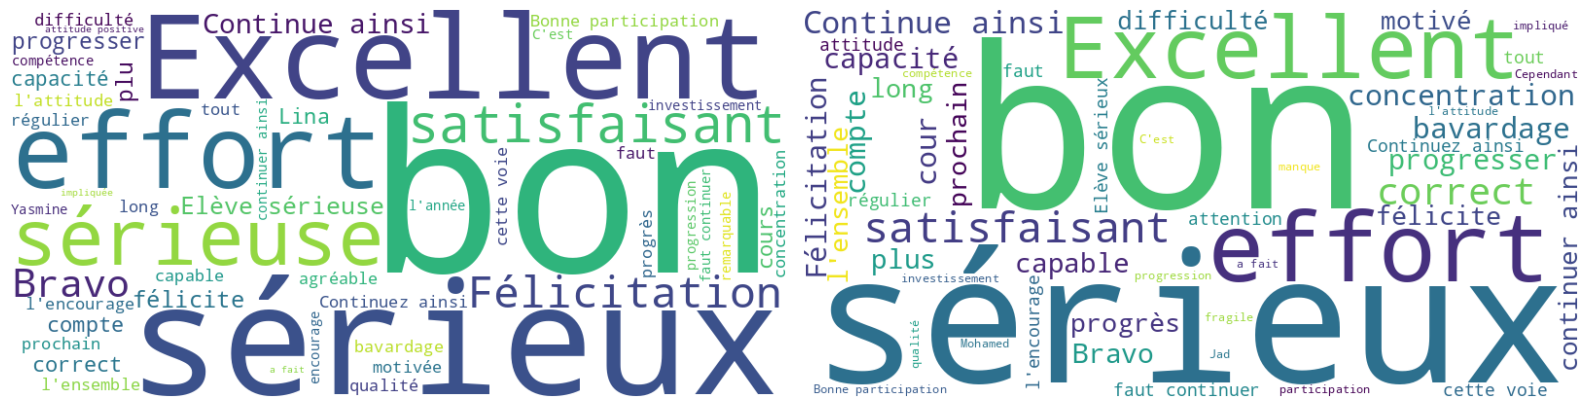

In [125]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt


# Création de nuages de mots
max_words=50
wordcloud_filles = WordCloud(width=800, height=400, background_color='white', stopwords=french_stopwords, max_words=max_words).generate(text_filles)
wordcloud_garcons = WordCloud(width=800, height=400, background_color='white', stopwords=french_stopwords, max_words=max_words).generate(text_garcons)

# Affichage côte à côte des nuages de mots
plt.figure(figsize=(16, 8))

# Nuage de mots pour les filles
plt.subplot(1, 2, 1)
plt.imshow(wordcloud_filles, interpolation='bilinear')

plt.axis('off')

# Nuage de mots pour les garçons
plt.subplot(1, 2, 2)
plt.imshow(wordcloud_garcons, interpolation='bilinear')

plt.axis('off')

plt.tight_layout()
plt.show()


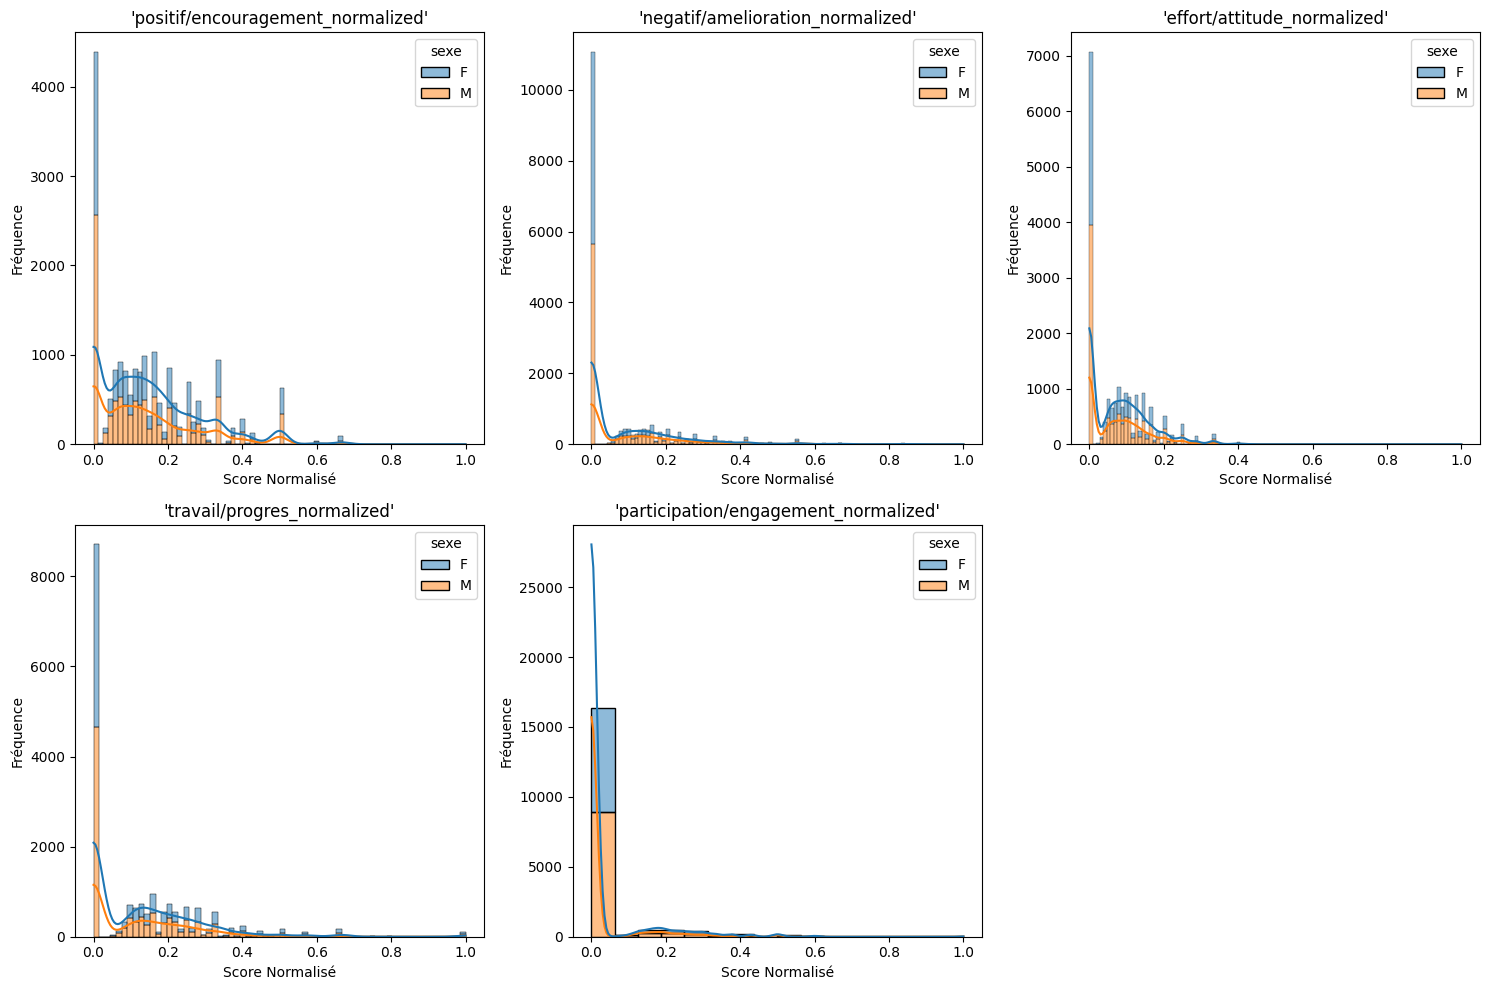

In [151]:
from collections import Counter
import re
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Définir les lexiques par thème
lexique_themes = {
    "positif/encouragement": {"bon", "excellent", "bravo", "bien", "félicitations", "satisfaisant",
                              "continue", "félicite", "positive", "agréable", "exemplaire", "réussir",
                              "exceller", "belle", "motivé", "excellents", "encourage", "continuer",
                              "bonne"},
    "negatif/amelioration": {"faut", "doit", "davantage", "difficultés", "bavardages", "manque",
                             "faudra", "encore", "peu", "attention", "long", "progresser",
                             "améliorer", "cependant"},
    "effort/attitude": {"sérieux", "sérieuse", "efforts", "attitude", "investissement", "concentration",
                        "implication", "capable", "motivation", "régulier", "progrès", "compte"},
    "travail/progres": {"résultats", "cours", "progression", "poursuivre", "qualité", "bilan",
                        "prochain", "voie", "capacités", "travailler", "compétences", "preuve"},
    "participation/engagement": {"participation", "engagement", "présence", "participe"}
}

# Liste simplifiée de stopwords en français
french_stopwords = set(stopwords.words('french'))

# Fonction pour nettoyer et tokeniser les textes
def get_words(text, stopwords):
    words = re.findall(r'\b\w+\b', text.lower())
    return [word for word in words if word not in stopwords]

# Fonction unique pour calculer les scores bruts et normalisés par thème pour chaque appréciation
def calculate_theme_scores_and_normalize(text):
    # Initialiser les scores pour chaque thème
    scores = {theme: 0 for theme in lexique_themes}
    words = get_words(text, french_stopwords)  # Nettoyage et tokenisation

    # Compter les mots par thème
    for word in words:
        for theme, lexique in lexique_themes.items():
            if word in lexique:
                scores[theme] += 1

    # Calculer un score global brut
    scores["score_global"] = sum(scores.values())

    # Compter le nombre total de mots dans l'appréciation pour la normalisation
    total_words = len(words)

    # Normalisation par la longueur du texte
    normalized_scores = {}
    if total_words > 0:
        for theme, score in scores.items():
            normalized_scores[theme + "_normalized"] = score / total_words
    else:
        normalized_scores = {theme + "_normalized": 0 for theme in scores}

    combined_scores = {**scores, **normalized_scores}
    return combined_scores

# Appliquer la fonction pour chaque appréciation
df_appreciationprofesseurs=data_pronote['Appreciationprofesseurs'].copy()
theme_scores_normalized_df = df_appreciationprofesseurs['appr'].apply(calculate_theme_scores_and_normalize)
theme_scores_normalized_df = pd.DataFrame(theme_scores_normalized_df.tolist())

# Application de la normalisation Min-Max pour chaque thème normalisé
for theme in lexique_themes.keys():
    normalized_col = theme + "_normalized"
    min_score = theme_scores_normalized_df[normalized_col].min()
    max_score = theme_scores_normalized_df[normalized_col].max()
    if max_score > min_score:
        theme_scores_normalized_df[normalized_col] = (
            (theme_scores_normalized_df[normalized_col] - min_score) / (max_score - min_score)
        )
    else:
        theme_scores_normalized_df[normalized_col] = 0.5

# Ajouter les scores Min-Max normalisés au DataFrame principal
df_appreciationprofesseurs = pd.concat([df_appreciationprofesseurs, theme_scores_normalized_df], axis=1)

# Liste des thèmes à afficher
themes_normalized = [theme + "_normalized" for theme in lexique_themes.keys()]

plt.figure(figsize=(15, 10))

# Boucle pour afficher un histogramme de distribution pour chaque thème
for i, theme in enumerate(themes_normalized, 1):
    plt.subplot(2, 3, i)
    sns.histplot(data=df_appreciationprofesseurs, x=theme, hue='sexe', multiple='stack', kde=True)
    plt.title(f"'{theme}'")
    plt.xlabel("Score Normalisé")
    plt.ylabel("Fréquence")

plt.tight_layout()
plt.show()


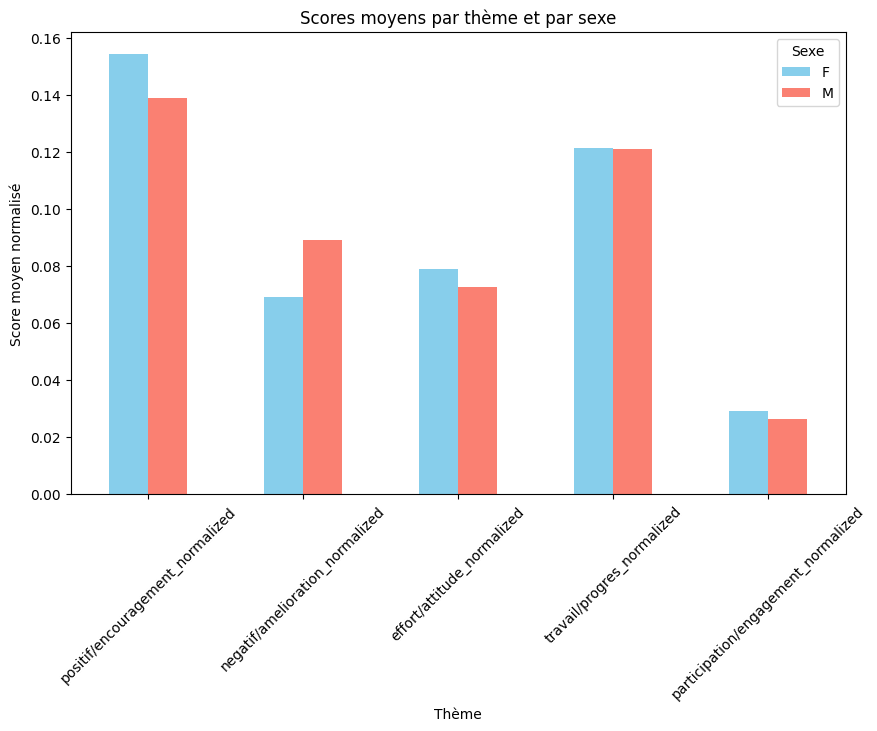

In [152]:
# Calculer la moyenne des scores normalisés par sexe
mean_scores_by_sex = df_appreciationprofesseurs.groupby('sexe')[themes_normalized].mean()

# Afficher le diagramme en barres pour les scores moyens
mean_scores_by_sex.T.plot(kind='bar', figsize=(10, 6), color=['skyblue', 'salmon'])
plt.title("Scores moyens par thème et par sexe")
plt.xlabel("Thème")
plt.ylabel("Score moyen normalisé")
plt.xticks(rotation=45)
plt.legend(title="Sexe")
plt.show()


Colonne positif/encouragement :
0    1
1    1
2    1
3    1
4    1
Name: positif/encouragement, dtype: int64


Colonne negatif/amelioration :
0    2
1    0
2    0
3    0
4    0
Name: negatif/amelioration, dtype: int64


Colonne effort/attitude :
0    2
1    0
2    0
3    1
4    0
Name: effort/attitude, dtype: int64


Colonne travail/progres :


KeyError: 'travail/progres'

ValueError: Could not interpret value `positif/encouragement` for parameter `x`

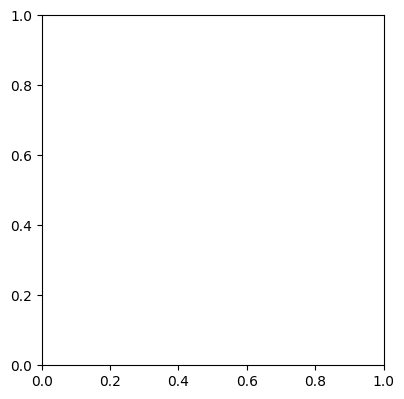

ValueError: Data must be 1-dimensional

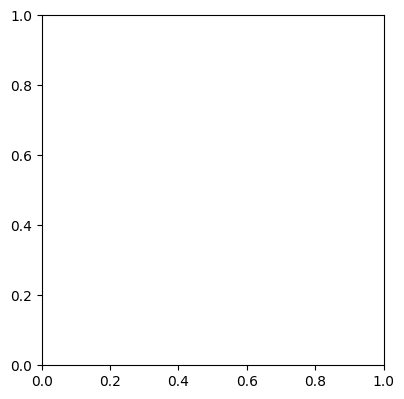

In [129]:
import matplotlib.pyplot as plt
import seaborn as sns



plt.figure(figsize=(15, 10))

# Boucle pour afficher un histogramme de distribution pour chaque thème
for i, theme in enumerate(themes_normalized, 1):
    plt.subplot(2, 3, i)
    sns.histplot(data=df_appreciationprofesseurs, x=theme, hue='sexe', multiple='stack', kde=True)
    plt.title(f"Distribution des scores normalisés du thème '{theme}' par sexe")
    plt.xlabel("Score Normalisé")
    plt.ylabel("Fréquence")

plt.tight_layout()
plt.show()


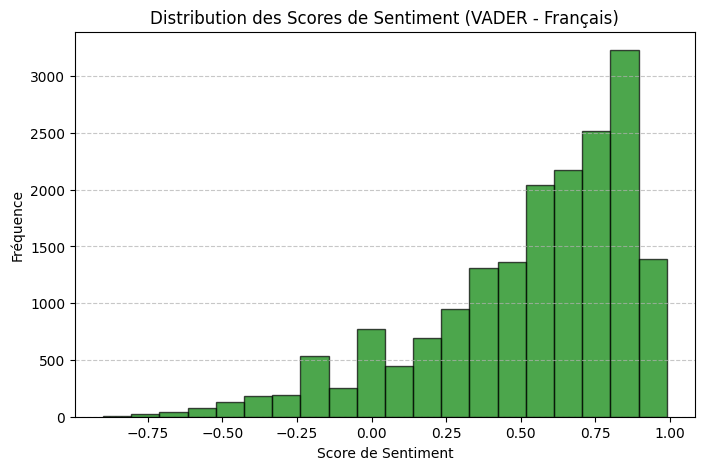

In [103]:
from vaderSentiment_fr.vaderSentiment import SentimentIntensityAnalyzer
import matplotlib.pyplot as plt

# Initialiser l'analyseur VADER pour le français
analyzer_fr = SentimentIntensityAnalyzer()

# Fonction pour obtenir le score VADER en français
def vader_score_fr(text):
    if not isinstance(text, str) or pd.isna(text):
        return {"compound": 0}  # Retourne un score neutre si le texte est manquant ou non valide
    return analyzer_fr.polarity_scores(text)

# Appliquer VADER en français à la colonne 'appr' de tout le DataFrame et extraire le score "compound"
df_appreciationprofesseurs['vader_FR_scores'] = df_appreciationprofesseurs['appr'].apply(vader_score_fr)
df_appreciationprofesseurs['vader_FR_compound'] = df_appreciationprofesseurs['vader_FR_scores'].apply(lambda x: x['compound'])

# Visualiser la distribution du score de sentiment VADER en français sur tout le DataFrame
vader_fr_scores = df_appreciationprofesseurs['vader_FR_compound'].dropna()

plt.figure(figsize=(8, 5))
plt.hist(vader_fr_scores, bins=20, edgecolor='black', alpha=0.7, color='green')
plt.title('Distribution des Scores de Sentiment (VADER - Français)')
plt.xlabel('Score de Sentiment')
plt.ylabel('Fréquence')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


In [87]:
from nltk.corpus import stopwords
import re

# Télécharger les stopwords français si nécessaire
import nltk
nltk.download('stopwords')

# Obtenir les stopwords français
french_stopwords = set(stopwords.words('french'))

# Liste des mots supplémentaires à ajouter comme stop words
custom_stopwords = {'faut',"trimestre", 'a', "travail",'ainsi',"classe", "année", "attitude", "élève", "niveau", "ensemble", "personnel"}

# Ajouter les mots supplémentaires à la liste de stop words
french_stopwords.update(custom_stopwords)

# Filtrer les mots de la colonne 'appr' en supprimant les stop words
filtered_words = []
for text in df_appreciationprofesseurs['appr'].dropna():
    words = re.findall(r'\b\w+\b', text.lower())  # Extraire les mots
    filtered_words.extend([word for word in words if word not in french_stopwords])

# Compter la fréquence des mots restants après suppression des stop words
filtered_word_counts = Counter(filtered_words)

# Afficher les 100 mots les plus fréquents après filtrage des stop words
filtered_word_counts.most_common(10)


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/mathieubartozzi/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


[('très', 6587),
 ('bon', 6171),
 ('résultats', 4621),
 ('sérieux', 3547),
 ('efforts', 2755),
 ('plus', 2402),
 ('excellent', 2225),
 ('bravo', 1723),
 ('bien', 1677),
 ('bonne', 1611)]

/Users/mathieubartozzi/.pyenv/versions/3.10.6/envs/projets_osui/lib/python3.10/site-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')
